# Inteligência Artificial - Trabalho Nº2 - Aprendizagem Computacional

### Temática 4: Aprendizagem Supervisionada – Regressão - European Soccer Database

## Autores:

* João Brandão - up201705573@fe.up.pt
* João Martins - up201605373@fe.up.pt
* José Martins - up201605497@fe.up.pt

FEUP 2019/2020

## Resumo

Este projeto foi desenvolvido no âmbito da unidade curricular de Inteligência Artificial da Faculdade de Engenharia da Universidade do Porto e tem como objetivo usar aprendizagem computacional de forma a construir modelos de regressão. Para tal, foram utilizados algoritmos de aprendizagem supervisionada e um dado dataset, o European Soccer Database. Este dataset conta com mais de 26 mil jogos e aproximadamente 11 mil jogadores.
O projeto foi concluído com sucesso, sendo que todo o seu desenvolvimento, resultados obtidos e conclusões, serão expostos neste notebook.

## 1. Introdução

O projeto realizado consiste na criação de um agente inteligente capaz de prever as “odds” de jogos de futebol. Para isso, inicialmente, foi realizada uma análise exploratória dos dados disponíveis sobre os jogadores e encontros realizados. Além disso, implementamos diferentes algoritmos de aprendizagem e posteriormente comparamos os seus desempenhos e tempo despendido para efetuar os testes.
Posto isto, o agente inteligente criado poderá ser utilizado para prever as “odds” da equipa da casa, da equipa visitante e de empate em qualquer jogo de futebol.

## 2. Referências

* https://github.com/nanazhu/DataMining-Football-Match-Prediction
* https://github.com/danleh/predict-euro2016
* https://github.com/yanuehara/ai-soccer-prediction

## 3. Algoritmos e ferramentas

Com a ajuda de algumas ferramentas, como o Jupyter, Scikit-learn, NumPy e Pandas, foram implementados quatro algoritmos:
+ Árvore de decisão
+ Redes neuronais
+ K-Nearest Neighbor
+ Support Vector Machines

Posteriormente, comparamos o desempenho destes algoritmos, tendo em conta os erros obtidos no processo de aprendizagem, a qualidade de previsão e o tempo necessário para a realização do treino e do teste.
Além disso, comparamos também os resultados obtidos pelos diferentes algoritmos, através de tabelas e gráficos. Para isso, usamos duas bibliotecas de visualização de dados, o Seaborn e o Matplotlib.

## 4. Abordagem

Inicialmente foi criado um novo dataset que possui informação sobre milhares de jogos de futebol, incluindo:
* O rating médio do 11 inicial de cada equipa, sendo o rating de cada jogador o mais recente à data do jogo, fornecido pelo videojogo FIFA.
* A forma de cada equipa, tendo em conta os últimos 5 jogos.
* A forma da equipa da casa em casa, tendo em conta os últimos 5 jogos em casa.
* A forma da equipa visitante em jogos fora, tendo em conta os últimos jogos fora.
* As odds da equipa da casa, da equipa visitante e de empate, fornecidas pelo Bet365

Após a criação deste dataset, construímos modelos de regressão que usam os dados indicados pelos primeiros 4 pontos para obter os dados indicados pelo 5º ponto, as odds do jogo.

### Imports 

Começamos por fazer os imports necessários para a realização este projeto

In [57]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', None)
%matplotlib inline

### Database

De seguida carregamos a database e criamos duas funções para recolher dados de uma tabela como um dataframe

In [58]:
db_location = "../Data/soccer/database.sqlite"

# Create dictionary
def dict_factory(cursor, row):
    d = {}
    for idx, col in enumerate(cursor.description):
        d[col[0]] = row[idx]
    return d


# Get dataframe with the given table
def get_table_as_pd_dataframe(table_name):
    query = 'SELECT * FROM ' + table_name + ';'

    con = sqlite3.connect(db_location)
    con.row_factory = dict_factory
    cur = con.cursor()

    cur.execute(query)
    table = cur.fetchall()

    con.close()

    return pd.DataFrame(table)

### Informação dos jogos
Começamos por criar um dataframe com a tabela Match, que contém toda a informação sobre os jogos realizados.

In [59]:
# Get matches from database
matches = get_table_as_pd_dataframe('Match')

matches

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

Depois atualizamos o dataframe, de forma a ter apenas as colunas necessárias para o desenvolvimento do projeto. Além disso, retiramos as linhas com valores nulos e organizamos os dados por época e data.

In [60]:
# Set dataframe with only the important columns
matches = matches[["id",
                    "season",
                    "date",
                    "home_team_api_id",
                    "away_team_api_id",
                    "home_team_goal",
                    "away_team_goal",
                    "home_player_1",
                    "home_player_2",
                    "home_player_3",
                    "home_player_4",
                    "home_player_5",
                    "home_player_6",
                    "home_player_7",
                    "home_player_8",
                    "home_player_9",
                    "home_player_10",
                    "home_player_11",
                    "away_player_1",
                    "away_player_2",
                    "away_player_3",
                    "away_player_4",
                    "away_player_5",
                    "away_player_6",
                    "away_player_7",
                    "away_player_8",
                    "away_player_9",
                    "away_player_10",
                    "away_player_11",
                    "B365H",
                    "B365D",
                    "B365A"]]

# Drop rows with null values
matches = matches.dropna()

# Sort by season and date
matches = matches.sort_values(by=['season', 'date'])

matches

,id,season,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A
4769,4770,2008/2009,2008-08-09 00:00:00,9827,7819,2,1,30458.0,32571.0,38703.0,40543.0,26119.0,39978.0,39962.0,33744.0,39963.0,31292.0,25537.0,11321.0,11324.0,26412.0,46338.0,11327.0,26420.0,26191.0,11329.0,18913.0,35410.0,46261.0,1.57,3.60,6.50
4770,4771,2008/2009,2008-08-09 00:00:00,9746,9831,1,0,41186.0,71607.0,38111.0,46447.0,103470.0,46651.0,46647.0,109590.0,46656.0,26405.0,41146.0,33617.0,26356.0,41121.0,26304.0,41019.0,30908.0,41122.0,26325.0,39987.0,94318.0,38108.0,2.30,3.00,3.40
4773,4774,2008/2009,2008-08-09 00:00:00,9829,9847,1,0,145039.0,41097.0,26216.0,39199.0,38729.0,71603.0,26120.0,32566.0,33435.0,51371.0,40762.0,30742.0,20482.0,94043.0,26357.0,30457.0,30695.0,35499.0,32578.0,32572.0,37554.0,26312.0,2.40,3.10,3.10
4774,4775,2008/2009,2008-08-09 00:00:00,8481,8639,0,0,26233.0,111909.0,31684.0,94313.0,26245.0,25538.0,46757.0,26227.0,26238.0,38951.0,26494.0,26150.0,26107.0,26149.0,77741.0,26154.0,26291.0,26160.0,20401.0,32575.0,35407.0,26156.0,2.15,3.10,3.60
4776,4777,2008/2009,2008-08-09 00:00:00,9874,9855,1,2,26359.0,147351.0,26345.0,26328.0,41178.0,36396.0,26371.0,26370.0,26374.0,34983.0,41238.0,26190.0,41302.0,26027.0,32755.0,46709.0,31037.0,93480.0,5217.0,26285.0,33599.0,103482.0,1.91,3.20,4.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24490,24491,2015/2016,2016-05-15 00:00:00,8603,8305,2,1,196126.0,186991.0,27461.0,39719.0,213688.0,37824.0,111801.0,535600.0,531629.0,2983.0,96652.0,109222.0,188540.0,112205.0,195335.0,100033.0,523390.0,37449.0,75192.0,240054.0,262592.0,183548.0,5.00,3.80,1.70
24491,24492,2015/2016,2016-05-15 00:00:00,8558,8372,4,2,532942.0,185123.0,257855.0,193930.0,358138.0,209922.0,88986.0,46836.0,107930.0,498033.0,246438.0,449484.0,242151.0,113311.0,33959.0,246218.0,156097.0,433311.0,40501.0,202553.0,193224.0,200917.0,2.00,3.60,3.70
24494,24495,2015/2016,2016-05-15 00:00:00,9864,8306,4,1,31047.0,41470.0,477471.0,41707.0,522203.0,573463.0,238841.0,112758.0,56686.0,75445.0,213653.0,477498.0,74991.0,291635.0,643570.0,183497.0,292262.0,46621.0,484906.0,213729.0,37510.0,179083.0,1.80,3.75,4.50
24496,24497,2015/2016,2016-05-15 00:00:00,8370,8581,3,1,192064.0,359194.0,150731.0,183449.0,406257.0,75004.0,420568.0,482331.0,427893.0,2802.0,46808.0,213504.0,287691.0,30276.0,40721.0,37484.0,105351.0,38469.0,150632.0,384413.0,466672.0,25462.0,1.33,5.25,9.00


Análise das odds da equipa da casa:

O valor mais baixo é: 1.04
O valor mais alto é: 26.0
O valor médio é: 2.6432771316845263


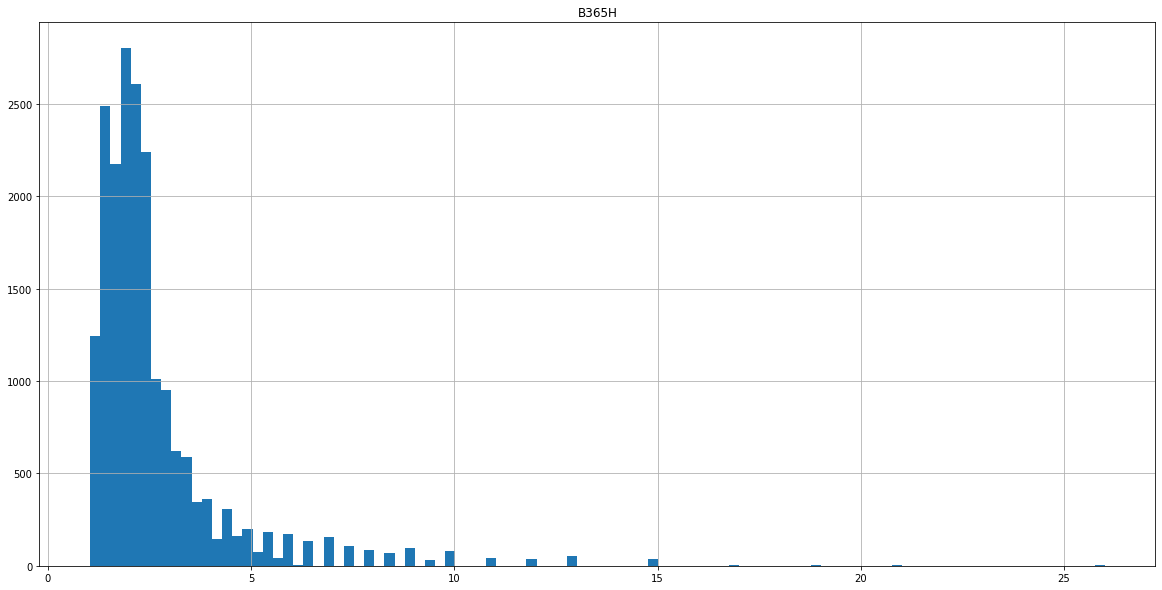

In [61]:
matches.hist(column='B365H', bins = 100,figsize=(20,10))

print("O valor mais baixo é: " + str(matches["B365H"].min()))
print("O valor mais alto é: " + str(matches["B365H"].max()))
print("O valor médio é: " + str(matches["B365H"].mean()))

plt.show()

Análise das odds de empate:

O valor mais baixo é: 1.4
O valor mais alto é: 17.0
O valor médio é: 3.8561027880757703


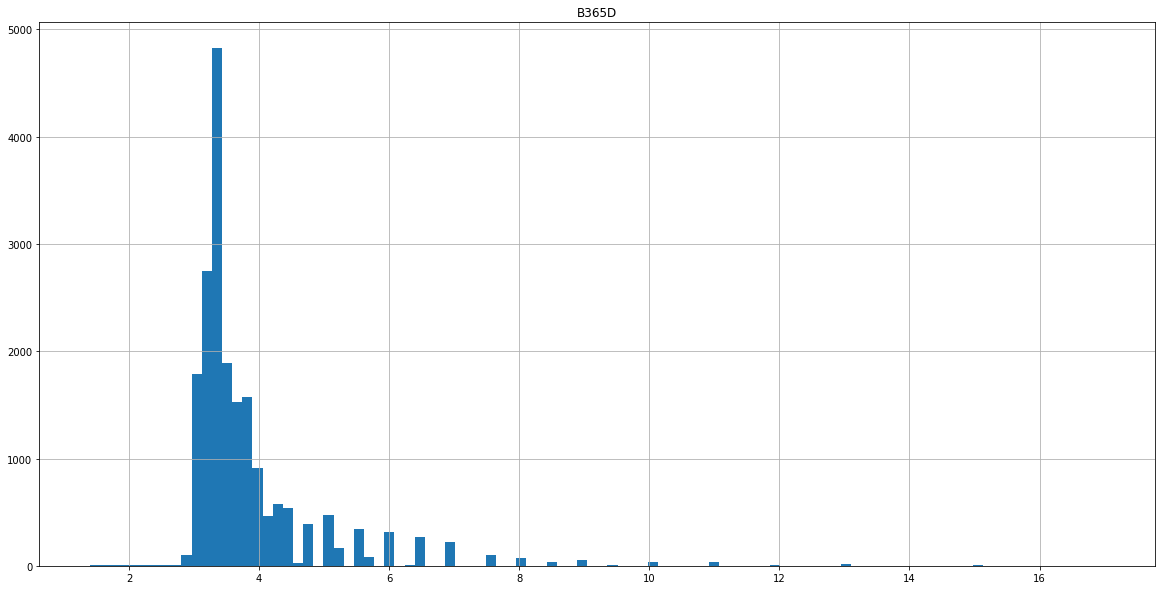

In [62]:
matches.hist(column='B365D', bins = 100,figsize=(20,10))

print("O valor mais baixo é: " + str(matches["B365D"].min()))
print("O valor mais alto é: " + str(matches["B365D"].max()))
print("O valor médio é: " + str(matches["B365D"].mean()))

plt.show()

Análise das odds da equipa visitante:

O valor mais baixo é: 1.08
O valor mais alto é: 51.0
O valor médio é: 4.6717068711594125


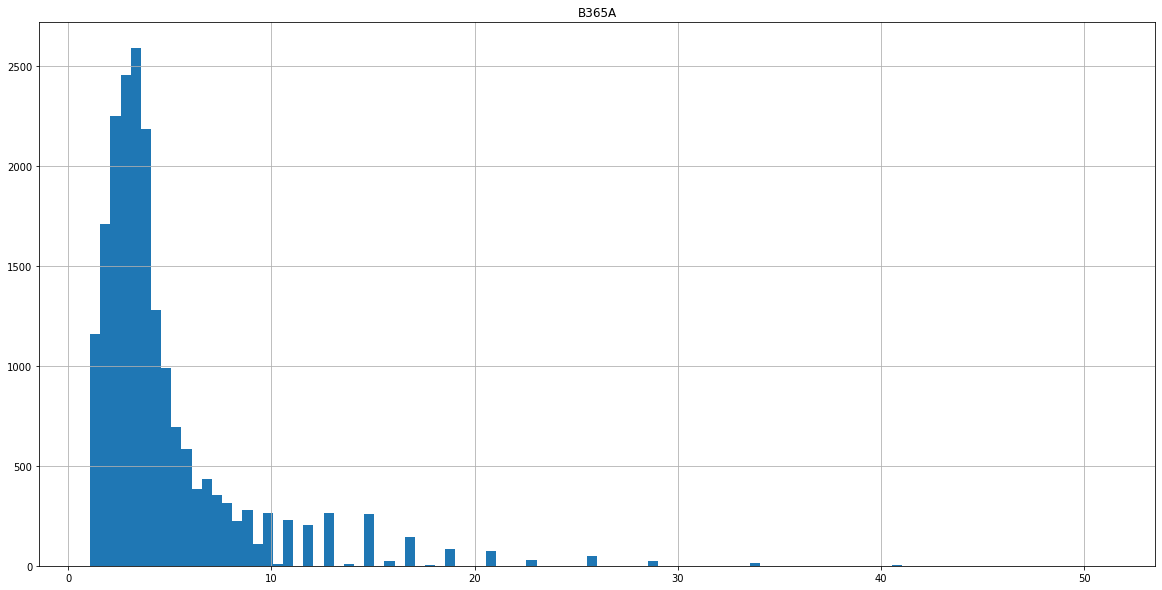

In [63]:
matches.hist(column='B365A', bins = 100,figsize=(20,10))

print("O valor mais baixo é: " + str(matches["B365A"].min()))
print("O valor mais alto é: " + str(matches["B365A"].max()))
print("O valor médio é: " + str(matches["B365A"].mean()))

plt.show()

### Informação dos jogadores
Depois criamos um dataframe com a tabela Player_Attributes, que contém informações sobre os jogadores.

In [64]:
# Get players from database
players = get_table_as_pd_dataframe('Player_Attributes')

players

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183973,183974,102359,39902,2009-08-30 00:00:00,83.0,85.0,right,medium,low,84.0,77.0,59.0,89.0,77.0,84.0,86.0,78.0,84.0,85.0,66.0,72.0,77.0,86.0,73.0,76.0,58.0,72.0,67.0,81.0,56.0,78.0,86.0,88.0,83.0,22.0,31.0,30.0,9.0,20.0,84.0,20.0,20.0
183974,183975,102359,39902,2009-02-22 00:00:00,78.0,80.0,right,medium,low,74.0,76.0,53.0,84.0,77.0,85.0,86.0,74.0,73.0,86.0,66.0,67.0,77.0,74.0,73.0,75.0,58.0,66.0,65.0,73.0,61.0,64.0,72.0,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
183975,183976,102359,39902,2008-08-30 00:00:00,77.0,80.0,right,medium,low,74.0,71.0,53.0,84.0,77.0,85.0,86.0,74.0,73.0,86.0,66.0,67.0,77.0,74.0,73.0,75.0,58.0,66.0,65.0,73.0,67.0,64.0,72.0,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
183976,183977,102359,39902,2007-08-30 00:00:00,78.0,81.0,right,medium,low,74.0,64.0,57.0,86.0,77.0,87.0,86.0,73.0,73.0,91.0,61.0,60.0,77.0,69.0,73.0,72.0,58.0,67.0,59.0,78.0,63.0,63.0,68.0,88.0,53.0,28.0,32.0,30.0,9.0,20.0,73.0,20.0,20.0


Também para este dataframe escolhemos as coluna essenciais, retiramos as linhas com valores nulos e ordenamos por data e rating.

In [65]:
# Set dataframe with only the important columns
players = players[["id",
                    "player_api_id",
                    "date",
                    "overall_rating"]]

# Drop rows with null values
players = players.dropna()

# Sort by date and rating
players = players.sort_values(by=['date', 'overall_rating'])

players

,id,player_api_id,date,overall_rating
57834,57835,41841,2007-02-22 00:00:00,33.0
76552,76553,127644,2007-02-22 00:00:00,35.0
132235,132236,41496,2007-02-22 00:00:00,35.0
65309,65310,35523,2007-02-22 00:00:00,36.0
131650,131651,47341,2007-02-22 00:00:00,36.0
...,...,...,...,...
153508,153509,45400,2016-07-07 00:00:00,68.0
1329,1330,495841,2016-07-07 00:00:00,72.0
19675,19676,210065,2016-07-07 00:00:00,72.0
57229,57230,184521,2016-07-07 00:00:00,73.0


Análise dos overall_ratings dos jogadores:

O overall rating mais baixo é: 33.0
O overall rating mais alto é: 94.0
O overall rating médio é: 68.6000152886831


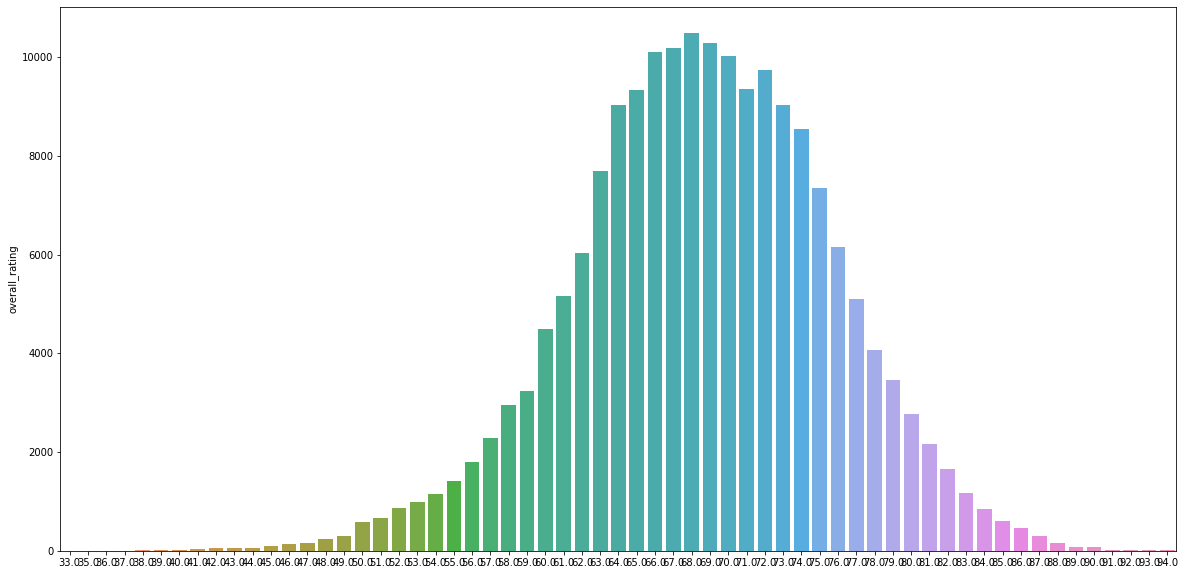

In [66]:
print("O overall rating mais baixo é: " + str(players["overall_rating"].min()))
print("O overall rating mais alto é: " + str(players["overall_rating"].max()))
print("O overall rating médio é: " + str(players["overall_rating"].mean()))

plt.figure(figsize=(20,10))
rating_series = players.overall_rating.value_counts()
sb.barplot(x=rating_series.index, y=rating_series)

### Dataframe da época 2008/2009

Para a criação de um dataframe com todos os pontos que referimos anteriormente, decidimos dividir os dataframes com a informação de jogos e de jogadores por épocas e criar funções que calculam e recolhem dados apenas relativos a uma dada época. Decidimos fazer desta forma pois é mais eficiente em termos de tempo para ir recolher, por exemplo, os ratings dos jogadores à data de um jogo, pois demorará menos tempo a encontrar uma data específica. Portanto, para acompanhar a criação das funções, primeiro iremos fazer um dataframe para a época de 2008/2009, pois é a primeira que temos disponível. Posteriormente, iremos iterar sobre todas as épocas de forma a ir buscar os dados de cada uma e juntar tudo num dataframe.

Começamos por recolher os dados dos jogos da época 2008/2009.

In [67]:
season_filter = (matches["season"] == "2008/2009")
matches_08_09 = matches.loc[season_filter]

matches_08_09

,id,season,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A
4769,4770,2008/2009,2008-08-09 00:00:00,9827,7819,2,1,30458.0,32571.0,38703.0,40543.0,26119.0,39978.0,39962.0,33744.0,39963.0,31292.0,25537.0,11321.0,11324.0,26412.0,46338.0,11327.0,26420.0,26191.0,11329.0,18913.0,35410.0,46261.0,1.57,3.60,6.50
4770,4771,2008/2009,2008-08-09 00:00:00,9746,9831,1,0,41186.0,71607.0,38111.0,46447.0,103470.0,46651.0,46647.0,109590.0,46656.0,26405.0,41146.0,33617.0,26356.0,41121.0,26304.0,41019.0,30908.0,41122.0,26325.0,39987.0,94318.0,38108.0,2.30,3.00,3.40
4773,4774,2008/2009,2008-08-09 00:00:00,9829,9847,1,0,145039.0,41097.0,26216.0,39199.0,38729.0,71603.0,26120.0,32566.0,33435.0,51371.0,40762.0,30742.0,20482.0,94043.0,26357.0,30457.0,30695.0,35499.0,32578.0,32572.0,37554.0,26312.0,2.40,3.10,3.10
4774,4775,2008/2009,2008-08-09 00:00:00,8481,8639,0,0,26233.0,111909.0,31684.0,94313.0,26245.0,25538.0,46757.0,26227.0,26238.0,38951.0,26494.0,26150.0,26107.0,26149.0,77741.0,26154.0,26291.0,26160.0,20401.0,32575.0,35407.0,26156.0,2.15,3.10,3.60
4776,4777,2008/2009,2008-08-09 00:00:00,9874,9855,1,2,26359.0,147351.0,26345.0,26328.0,41178.0,36396.0,26371.0,26370.0,26374.0,34983.0,41238.0,26190.0,41302.0,26027.0,32755.0,46709.0,31037.0,93480.0,5217.0,26285.0,33599.0,103482.0,1.91,3.20,4.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10567,10568,2008/2009,2009-05-31 00:00:00,8636,8524,4,3,30989.0,30460.0,22984.0,30492.0,27692.0,30905.0,30930.0,30724.0,108808.0,35724.0,30696.0,39170.0,41930.0,39210.0,41869.0,39201.0,31207.0,27671.0,42579.0,42645.0,38762.0,42696.0,1.44,4.00,8.00
10568,10569,2008/2009,2009-05-31 00:00:00,8600,8529,6,2,42422.0,109298.0,24970.0,27719.0,39357.0,25818.0,39644.0,111862.0,39232.0,39540.0,41542.0,39313.0,18923.0,103266.0,24403.0,24414.0,39222.0,39538.0,41404.0,41326.0,42091.0,39474.0,1.75,3.60,4.50
10570,10571,2008/2009,2009-05-31 00:00:00,8535,8564,0,2,24503.0,39621.0,24504.0,39729.0,24536.0,24507.0,24502.0,24453.0,92666.0,39719.0,30881.0,30720.0,34534.0,32752.0,26099.0,30870.0,30612.0,30731.0,23688.0,41044.0,26096.0,30729.0,2.50,3.10,2.88
10573,10574,2008/2009,2009-05-31 00:00:00,9875,8533,3,0,18558.0,41666.0,27668.0,39509.0,41337.0,41887.0,41309.0,41658.0,41350.0,41328.0,18925.0,41807.0,39273.0,113762.0,39721.0,24443.0,27731.0,42581.0,42003.0,39264.0,24448.0,32750.0,1.62,3.75,5.50


De seguida, fazemos o mesmo para os dados dos jogadores.

In [68]:
# Get first and last date of the season
first_date = matches_08_09["date"].min()
last_date = matches_08_09["date"].max()

# Get player data between those dates
date_filter = ((players["date"] >= first_date) & (players["date"] <= last_date))

players_08_09 = players.loc[date_filter]

players_08_09

,id,player_api_id,date,overall_rating
76551,76552,127644,2008-08-30 00:00:00,35.0
35002,35003,35828,2008-08-30 00:00:00,38.0
107272,107273,118822,2008-08-30 00:00:00,39.0
131648,131649,47341,2008-08-30 00:00:00,39.0
181427,181428,168342,2008-08-30 00:00:00,39.0
...,...,...,...,...
183688,183689,35724,2009-02-22 00:00:00,89.0
33351,33352,30893,2009-02-22 00:00:00,90.0
63872,63873,30717,2009-02-22 00:00:00,90.0
102504,102505,30981,2009-02-22 00:00:00,90.0


Começamos a construir o dataframe para a época 2008/2009 com os valores de id e home_team_api_id da tabela de jogos referentes a esta época.

In [69]:
id_dictionary = {
    "id": [],
    "home_team_api_id": []
}

for index, row in matches_08_09.iterrows():
    match_id = row["id"]
    home_team_id = row["home_team_api_id"]
    
    id_dictionary["id"].append(match_id)
    id_dictionary["home_team_api_id"].append(home_team_id)
        
df_08_09 = pd.DataFrame(data = id_dictionary)

df_08_09

,id,home_team_api_id
0,4770,9827
1,4771,9746
2,4774,9829
3,4775,8481
4,4777,9874
...,...,...
1721,10568,8636
1722,10569,8600
1723,10571,8535
1724,10574,9875


De seguida vamos adicionar os ratings das equipas que jogam em casa ao dataframe. Para isso criamos duas funções para conseguir calcular o rating médio do 11 inicial

In [70]:
# Get player rating from season_players dataframe, and given the match date
def get_player_rating(date, player, season_players):
    player_filter = (season_players["player_api_id"] == player)
    date_filter = (season_players["date"] <= date)
    filt = (player_filter & date_filter)
    player_info = season_players.loc[filt]
    
    # If last rating is not from this season
    if (player_info.empty):
        player_filter = (players["player_api_id"] == player)
        date_filter = (players["date"] <= date)
        filt = (player_filter & date_filter)
        player_info = players.loc[filt]
    
    # Closest date to the match
    closest_date = player_info.loc[:, "date"].max()
    
    # Get rating
    date_filter = (player_info["date"] == closest_date)
    rating = player_info.loc[date_filter, "overall_rating"].item()
    return rating
  
    
# Get team rating from match of season_matches
def get_team_rating(condition, index, season_matches, season_players):
    date = season_matches.loc[index, "date"]
    
    team_rating = 0
    
    # Add all the player ratings
    for player_num in range(1, 12):
        column = condition + "_player_" + str(player_num)
        player = season_matches.loc[index, column]
        player_rating = get_player_rating(date, player, season_players)
        team_rating = team_rating + player_rating
    
    # Do the average
    team_rating = team_rating/11.0
    return team_rating


rating_dictionary = {
    "home_team_rating": []
}

for index, row in matches_08_09.iterrows():
    home_team_rating = get_team_rating("home", index, matches_08_09, players_08_09)
    
    rating_dictionary["home_team_rating"].append(home_team_rating)
        
rating_df = pd.DataFrame(data = rating_dictionary)
df_08_09 = df_08_09.join(rating_df)

df_08_09

,id,home_team_api_id,home_team_rating
0,4770,9827,74.454545
1,4771,9746,64.909091
2,4774,9829,67.909091
3,4775,8481,69.818182
4,4777,9874,69.545455
...,...,...,...
1721,10568,8636,83.636364
1722,10569,8600,77.181818
1723,10571,8535,79.727273
1724,10574,9875,74.818182


Depois vamos adicionar a forma da equipa da casa. A forma é calculada através da média de pontos ganhos nos ultimos 5 jogos. Foram criadas duas funções para efetuar esse calculo.

In [71]:
# Get points earned by team on a given match
def get_result(team_id, team_filter, date, season_matches):
    # Get match, given date
    date_filter = (season_matches["date"] == date)
    filt = (team_filter & date_filter)
    match = season_matches.loc[filt]
    
    # Get goals scored
    home_goals = match["home_team_goal"].item()
    away_goals = match["away_team_goal"].item()
    
    if match["home_team_api_id"].item() == team_id:
        if home_goals > away_goals:
            return 3
        elif home_goals < away_goals:
            return 0
        else:
            return 1
    else:
        if away_goals > home_goals:
            return 3
        elif away_goals < home_goals:
            return 0
        else:
            return 1

        
# Get form of the team, wich is a value from 0 to 3
def get_form(team_id, team_filter, date, season_matches):
    # Get last matches
    date_filter = (season_matches["date"] < date)
    filt = (team_filter & date_filter)
    last_matches = season_matches.loc[filt]
    
    # Get last 5
    last_5_matches = last_matches.tail(5)
    
    if (last_5_matches.empty):
        return 0
    
    form = 0
    
    # Add total points
    for index, row in last_5_matches.iterrows():
        match_date = row["date"]
        result = get_result(team_id, team_filter, match_date, season_matches)
        form = form + result
    
    # Average number of points
    index = last_5_matches.index
    num_matches = len(index)
    form = form / num_matches
    
    return form

form_dictionary = {
    "home_team_form": []
}

for index, row in matches_08_09.iterrows():
    team_id = row["home_team_api_id"]
    date = row["date"]
    team_filter = ((matches_08_09["home_team_api_id"] == team_id) | (matches_08_09["away_team_api_id"] == team_id))
    home_team_form = get_form(team_id, team_filter, date, matches_08_09)
    
    form_dictionary["home_team_form"].append(home_team_form)
        
form_df = pd.DataFrame(data = form_dictionary)
df_08_09 = df_08_09.join(form_df)

df_08_09

,id,home_team_api_id,home_team_rating,home_team_form
0,4770,9827,74.454545,0.0
1,4771,9746,64.909091,0.0
2,4774,9829,67.909091,0.0
3,4775,8481,69.818182,0.0
4,4777,9874,69.545455,0.0
...,...,...,...,...
1721,10568,8636,83.636364,1.2
1722,10569,8600,77.181818,2.6
1723,10571,8535,79.727273,2.0
1724,10574,9875,74.818182,0.8


Agora adicionamos a forma da equipa da casa em jogos em casa. Para calcular a forma usamos as mesmas funções definidas anteriormente.

In [72]:
home_form_dictionary = {
    "home_team_form_at_home": []
}

for index, row in matches_08_09.iterrows():
    team_id = row["home_team_api_id"]
    date = row["date"]
    team_filter = (matches_08_09["home_team_api_id"] == team_id)
    home_team_form_at_home = get_form(team_id, team_filter, date, matches_08_09)
    
    home_form_dictionary["home_team_form_at_home"].append(home_team_form_at_home)
        
home_form_df = pd.DataFrame(data = home_form_dictionary)
df_08_09 = df_08_09.join(home_form_df)

df_08_09

,id,home_team_api_id,home_team_rating,home_team_form,home_team_form_at_home
0,4770,9827,74.454545,0.0,0.0
1,4771,9746,64.909091,0.0,0.0
2,4774,9829,67.909091,0.0,0.0
3,4775,8481,69.818182,0.0,0.0
4,4777,9874,69.545455,0.0,0.0
...,...,...,...,...,...
1721,10568,8636,83.636364,1.2,2.2
1722,10569,8600,77.181818,2.6,2.0
1723,10571,8535,79.727273,2.0,2.4
1724,10574,9875,74.818182,0.8,1.0


Para finalizar o dataframe relativo à época de 2008/2009, utilizamos as funções definidas anteriormente para adicionar os dados relativos à equipa visitante.

In [73]:
away_dictionary = {
    "away_team_api_id": [],
    "away_team_rating": [],
    "away_team_form": [],
    "away_team_form_away": []
}

for index, row in matches_08_09.iterrows():
    away_team_id = row["away_team_api_id"]
    
    away_team_rating = get_team_rating("away", index, matches_08_09, players_08_09)
    
    date = row["date"]
    
    team_filter = ((matches_08_09["home_team_api_id"] == away_team_id) | (matches_08_09["away_team_api_id"] == away_team_id))
    away_team_form = get_form(away_team_id, team_filter, date, matches_08_09)
    
    team_filter = (matches_08_09["away_team_api_id"] == away_team_id)
    away_team_form_away = get_form(away_team_id, team_filter, date, matches_08_09)
    
    away_dictionary["away_team_api_id"].append(away_team_id)
    away_dictionary["away_team_rating"].append(away_team_rating)
    away_dictionary["away_team_form"].append(away_team_form)
    away_dictionary["away_team_form_away"].append(away_team_form_away)
    
away_df = pd.DataFrame(data = away_dictionary)
df_08_09 = df_08_09.join(away_df)

df_08_09

,id,home_team_api_id,home_team_rating,home_team_form,home_team_form_at_home,away_team_api_id,away_team_rating,away_team_form,away_team_form_away
0,4770,9827,74.454545,0.0,0.0,7819,69.454545,0.0,0.0
1,4771,9746,64.909091,0.0,0.0,9831,68.818182,0.0,0.0
2,4774,9829,67.909091,0.0,0.0,9847,73.363636,0.0,0.0
3,4775,8481,69.818182,0.0,0.0,8639,72.454545,0.0,0.0
4,4777,9874,69.545455,0.0,0.0,9855,65.090909,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1721,10568,8636,83.636364,1.2,2.2,8524,73.000000,1.0,1.2
1722,10569,8600,77.181818,2.6,2.0,8529,72.090909,1.0,1.0
1723,10571,8535,79.727273,2.0,2.4,8564,80.909091,1.4,2.0
1724,10574,9875,74.818182,0.8,1.0,8533,71.000000,0.8,1.8


### Dataframe final

Tendo criado todas as funções necessárias para a recolha de dados e a criação de um dataframe relativo a uma época, o próximo passo será criar um dataframe relativo a todas as épocas, iterando estas funções para cada época fornecida pela base de dados

In [74]:
# Get season name
def get_season(year):
    year2 = year + 1
    years = str(year)
    year2s = str(year2)
        
    season = years + "/" + year2s
    
    return season


dictionary = {
        "id": [],
        "home_team_api_id": [],
        "home_team_rating": [],
        "home_team_form": [],
        "home_team_form_at_home": [],
        "away_team_api_id": [],
        "away_team_rating": [],
        "away_team_form": [],
        "away_team_form_away": [],
        "B365H": [],
        "B365D": [],
        "B365A": []
    }

year = 2008

# While there are remaining seasons
while 1:
    season = get_season(year)
    season_filter = (matches["season"] == season)
    season_matches = matches.loc[season_filter]
    
    # If season is empty break
    if season_matches.empty:
        break;
    
    first_date = season_matches.loc[:, "date"].min()
    last_date = season_matches.loc[:, "date"].max()
    date_filter = ((players["date"] >= first_date) & (players["date"] <= last_date))
    season_players = players.loc[date_filter]
     
    for index, row in season_matches.iterrows():
        match_id = row["id"]
        
        home_team_id = row["home_team_api_id"]
        
        home_team_rating = get_team_rating("home", index, season_matches, season_players)
        
        date = row["date"]
        team_filter = ((season_matches["home_team_api_id"] == home_team_id) | (season_matches["away_team_api_id"] == home_team_id))
        home_team_form = get_form(home_team_id, team_filter, date, season_matches)
        
        team_filter = (season_matches["home_team_api_id"] == home_team_id)
        home_team_form_at_home = get_form(home_team_id, team_filter, date, season_matches)
        
        away_team_id = row["away_team_api_id"]
    
        away_team_rating = get_team_rating("away", index, season_matches, season_players)
        
        team_filter = ((season_matches["home_team_api_id"] == away_team_id) | (season_matches["away_team_api_id"] == away_team_id))
        away_team_form = get_form(away_team_id, team_filter, date, season_matches)
        
        team_filter = (season_matches["away_team_api_id"] == away_team_id)
        away_team_form_away = get_form(away_team_id, team_filter, date, season_matches)
        
        b365h = row["B365H"]
        b365d = row["B365D"]
        b365a = row["B365A"]
        
        dictionary["id"].append(match_id)
        dictionary["home_team_api_id"].append(home_team_id)
        dictionary["home_team_rating"].append(home_team_rating)
        dictionary["home_team_form"].append(home_team_form)
        dictionary["home_team_form_at_home"].append(home_team_form_at_home)
        dictionary["away_team_api_id"].append(away_team_id)
        dictionary["away_team_rating"].append(away_team_rating)
        dictionary["away_team_form"].append(away_team_form)
        dictionary["away_team_form_away"].append(away_team_form_away)
        dictionary["B365H"].append(b365h)
        dictionary["B365D"].append(b365d)
        dictionary["B365A"].append(b365a)
        
    year = year + 1
        
df = pd.DataFrame(data = dictionary)

df

,id,home_team_api_id,home_team_rating,home_team_form,home_team_form_at_home,away_team_api_id,away_team_rating,away_team_form,away_team_form_away,B365H,B365D,B365A
0,4770,9827,74.454545,0.0,0.0,7819,69.454545,0.0,0.0,1.57,3.60,6.50
1,4771,9746,64.909091,0.0,0.0,9831,68.818182,0.0,0.0,2.30,3.00,3.40
2,4774,9829,67.909091,0.0,0.0,9847,73.363636,0.0,0.0,2.40,3.10,3.10
3,4775,8481,69.818182,0.0,0.0,8639,72.454545,0.0,0.0,2.15,3.10,3.60
4,4777,9874,69.545455,0.0,0.0,9855,65.090909,0.0,0.0,1.91,3.20,4.33
...,...,...,...,...,...,...,...,...,...,...,...,...
19686,24491,8603,75.727273,1.0,1.8,8305,74.636364,1.0,0.6,5.00,3.80,1.70
19687,24492,8558,74.363636,0.8,2.0,8372,73.090909,1.0,0.4,2.00,3.60,3.70
19688,24495,9864,75.545455,0.8,1.6,8306,71.363636,1.0,1.8,1.80,3.75,4.50
19689,24497,8370,72.909091,0.8,1.4,8581,73.272727,1.4,0.2,1.33,5.25,9.00


## Modelos de regressão

Foram implementados quatro algoritmos:

* Árvore de decisão
* Redes neuronais
* K-Nearest Neighbor
* Support Vector Machines

Para facilitar a compreensão e comparação dos dados serão incluídas tabelas e gráficos que ajudam a interpretar e comparar resultados.

Começamos por dividir os dados em dois conjuntos: o conjunto de treino e o conjunto de teste. Iremos usar 80% dos dados para o treino e os restantes 20% para o teste.

In [75]:
%%time

#split data into training and test

test_df = df.drop(["home_team_api_id", "away_team_api_id"], axis=1)

odds_df = matches.loc[:, ["B365H", "B365D", "B365A"]]

matches_train, matches_test, odds_train, odds_test = train_test_split(test_df.drop(["id", "B365H", "B365D", "B365A"], axis=1), odds_df, test_size=0.20)

CPU times: user 6.91 ms, sys: 0 ns, total: 6.91 ms
Wall time: 5.98 ms


### Árvores de Decisão

Primeiro vamos analisar as Árvores de Decisão, começando por criar uma Árvore de Decisão básica sem mexer nos seus parâmetros.

In [76]:
%%time

#decision tree

decision_tree = MultiOutputRegressor(DecisionTreeRegressor(random_state = 0))

decision_tree.fit(matches_train, odds_train)

decision_tree_output = decision_tree.predict(matches_test)

print("Score: " + str(decision_tree.score(matches_test, odds_test)))

decision_tree_output

Score: 0.48874483246481093
CPU times: user 151 ms, sys: 1e+03 ns, total: 151 ms
Wall time: 150 ms


array([[2.7 , 3.2 , 2.87],
       [1.91, 3.4 , 3.6 ],
       [2.1 , 3.6 , 2.05],
       ...,
       [3.6 , 3.2 , 2.63],
       [4.75, 3.3 , 2.25],
       [2.1 , 4.  , 3.5 ]])

In [127]:
pipe_tree = Pipeline([("scl", StandardScaler()),
("reg", MultiOutputRegressor(DecisionTreeRegressor()))])

decision_tree_param_grid = {
    'reg__estimator__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'reg__estimator__max_features': [1, 2, 3, 4, 5, 6]
}

gs_svr = (GridSearchCV(estimator=pipe_tree,
                        param_grid=decision_tree_param_grid,
                        cv=2,
                        n_jobs = -1))

gs_svr = gs_svr.fit(matches_train, odds_train)
decision_tree_regressor = gs_svr.best_estimator_

decision_tree_regressor

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 MultiOutputRegressor(estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                      criterion='mse',
                                                                      max_depth=7,
                                                                      max_features=6,
                                                                      max_leaf_nodes=None,
                                                                      min_impurity_decrease=0.0,
                                                                      min_impurity_split=None,
                                                                      min_samples_leaf=1,
                                                                      min_samples_split=2,
                                                 

In [88]:
scores = cross_val_score(decision_tree_regressor, test_df.drop(["id", "B365H", "B365D", "B365A"], axis=1), odds_df, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.60 (+/- 0.22)


In [109]:
%%time

#neural network

from sklearn.neural_network import MLPRegressor

nn_parameter_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

nn_search = GridSearchCV(MLPRegressor(max_iter=1000, random_state=1), nn_parameter_grid, n_jobs = -1)

nn_search.fit(matches_train, odds_train)

neural_network = grid_search.best_estimator_

neural_network

CPU times: user 3.24 s, sys: 136 ms, total: 3.38 s
Wall time: 2min 57s


MLPRegressor(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=1000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [130]:
%%time

#k nearest neighbor

from sklearn.neighbors import KNeighborsRegressor

kn_pipe = Pipeline([("scl", StandardScaler()),
    ("reg", MultiOutputRegressor(KNeighborsRegressor(n_jobs=-1)))])

knearest_param_grid = {
    'reg__estimator__n_neighbors': [1, 3, 5, 7, 9],
    'reg__estimator__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'reg__estimator__weights': ['uniform', 'distance']
}

kn_search = GridSearchCV(
    kn_pipe,
    knearest_param_grid,
    n_jobs = -1
)

kn_search = kn_search.fit(matches_train, odds_train)
knn = gs_svr.best_estimator_

knn

CPU times: user 435 ms, sys: 46 ms, total: 481 ms
Wall time: 1min 25s


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 MultiOutputRegressor(estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                      criterion='mse',
                                                                      max_depth=7,
                                                                      max_features=6,
                                                                      max_leaf_nodes=None,
                                                                      min_impurity_decrease=0.0,
                                                                      min_impurity_split=None,
                                                                      min_samples_leaf=1,
                                                                      min_samples_split=2,
                                                 

In [84]:
%%time

#support vector machines

from sklearn.svm import SVR

svm = MultiOutputRegressor(SVR())

svm.fit(matches_train, odds_train)

svm_output = svm.predict(matches_test)

print(svm.score(matches_test, odds_test))

svm_output

0.4217177817010052
CPU times: user 29.5 s, sys: 44 ms, total: 29.5 s
Wall time: 29.5 s


array([[3.084481  , 3.39794133, 2.62790672],
       [2.00501996, 3.45255368, 4.05733853],
       [2.89433694, 3.44129628, 3.07884186],
       ...,
       [3.46713819, 3.30171383, 1.86240328],
       [3.41280034, 3.44379491, 2.23742674],
       [2.20542397, 3.50995888, 4.18137449]])

In [ ]:
svm_net = Pipeline([("scl", StandardScaler()),
    ("reg", MultiOutputRegressor(SVR()))])

svm_param_grid = {
    'reg__estimator__degree': [2,3,4],
    'reg__estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

gs_svr = (GridSearchCV(estimator=svm_net,
                        param_grid=svm_param_grid,
                        n_jobs = -1))

gs_svr = gs_svr.fit(matches_train, odds_train)
svm = gs_svr.best_estimator_

print(svm.score(matches_test, odds_test))
